In [15]:
import pandas as pd
import requests
import pickle
from datetime import datetime as dt
import matplotlib.pyplot as plt

In [2]:
def get_data(week_nums):
    url = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt"
    dfs = []
    for week_num in week_nums:
        file_url = url.format(week_num)
        dfs.append(pd.read_csv(file_url))
    return pd.concat(dfs)

In [3]:
#Rutine to clean and format the MTA data
def clean_n_format(turns_df, upper_lim):
    turns_df.rename(columns={column:column.strip() for column in turns_df.columns}, inplace=True)
    turns_stations = turns_df 
    #Getting entries and exits per time interval
    turns_stations[["REAL_ENTRIES", "REAL_EXITS"]] = (turns_stations.groupby(["C/A", "UNIT", "SCP", "STATION","DATE"])
                                                  ["ENTRIES", "EXITS"]
                                                  .transform(lambda x: x - x.shift(1)))
    #Droping negative entries and exits
    turns_stations = (turns_stations.drop(turns_stations
                    [(turns_stations["REAL_EXITS"] < 0) | (turns_stations["REAL_ENTRIES"] < 0)].index))
    turns_stations["TOTAL_REAL"] = turns_stations["REAL_ENTRIES"] + turns_stations["REAL_EXITS"]
    turns_stations = (turns_stations.drop(turns_stations[turns_stations["TOTAL_REAL"] > upper_lim].index))
    #Adding up all entries+exits for each station at a given date and time interval 
    turns_stations_day_time = ((turns_stations.groupby(["STATION","DATE","TIME"])).sum().sort_values("TOTAL_REAL", ascending = False)
                           .reset_index())
    return(turns_stations_day_time)

In [4]:
#Break it up into morning + afternoon chunks
def get_time_chunk(date_time_object):
    dow = date_time_object.strftime('%A')
    noon = date_time_object.replace(hour=12, minute=0, second=0)
    if date_time_object.time() < noon.time() :
        dow += ' Morning'
    else :
        dow += ' Afternoon'
    return dow

In [5]:
#week_ids = [180616, 180609, 180602,180526, 170617, 170610, 170603,170527, 160618, 160611, 160604,160528]
week_ids = [180616]

In [6]:
turns_df = get_data(week_ids)

In [7]:
turns_df_2 = clean_n_format(turns_df, 100000)

In [8]:
#Adding DATE_TIME column
turns_df_2["DATE_TIME"] = pd.to_datetime(turns_df_2.DATE + " " + turns_df_2.TIME, format="%m/%d/%Y %H:%M:%S")

In [9]:
#Break it up into morning + afternoon chunks
turns_df_2['DOW'] = turns_df_2['DATE_TIME'].apply(get_time_chunk)
turns_df_2.head()

,STATION,DATE,TIME,ENTRIES,EXITS,REAL_ENTRIES,REAL_EXITS,TOTAL_REAL,DATE_TIME,DOW
0,34 ST-HERALD SQ,06/13/2018,20:00:00,1551289666,1352903004,51895.0,31802.0,83697.0,2018-06-13 20:00:00,Wednesday Afternoon
1,34 ST-HERALD SQ,06/14/2018,20:00:00,1551408597,1353014165,50291.0,32937.0,83228.0,2018-06-14 20:00:00,Thursday Afternoon
2,34 ST-HERALD SQ,06/12/2018,20:00:00,1551169419,1352792806,51797.0,31364.0,83161.0,2018-06-12 20:00:00,Tuesday Afternoon
3,34 ST-PENN STA,06/13/2018,20:00:00,1908770123,1709205488,35127.0,46377.0,81504.0,2018-06-13 20:00:00,Wednesday Afternoon
4,34 ST-PENN STA,06/14/2018,20:00:00,1908891139,1709315617,34866.0,45821.0,80687.0,2018-06-14 20:00:00,Thursday Afternoon


In [10]:
turns_stations_timechunks = ((turns_df_2.groupby(["STATION","DOW"])).sum().reset_index())
turns_stations_timechunks.sort_values("TOTAL_REAL", ascending = False).head()

,STATION,DOW,ENTRIES,EXITS,REAL_ENTRIES,REAL_EXITS,TOTAL_REAL
837,34 ST-PENN STA,Wednesday Afternoon,11941724506,8836266926,120289.0,122848.0,243137.0
3230,GRD CNTRL-42 ST,Wednesday Afternoon,3070848076,2873378212,132764.0,109086.0,241850.0
3226,GRD CNTRL-42 ST,Thursday Afternoon,3071337959,2873819465,131325.0,109521.0,240846.0
833,34 ST-PENN STA,Thursday Afternoon,11942253813,8836718258,119023.0,120751.0,239774.0
3228,GRD CNTRL-42 ST,Tuesday Afternoon,3070350031,2872932957,130597.0,106536.0,237133.0


In [11]:
turns_stations_timechunks.to_csv("MTA_Sample.csv")

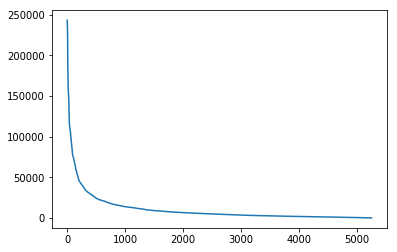

In [26]:
figura = plt.figure()
(turns_stations_timechunks.sort_values("TOTAL_REAL", ascending = False).reset_index())["TOTAL_REAL"].plot(y="Total number")


In [24]:
figura.savefig('Max_num.jpg')

In [31]:
(turns_stations_timechunks.sort_values("TOTAL_REAL", ascending = False).reset_index())["TOTAL_REAL"].head(20)

0      243137.0
1      241850.0
2      240846.0
3      239774.0
4      237133.0
5      235660.0
6      229911.0
7      226977.0
8      225633.0
9      213681.0
10     185998.0
11     184586.0
12     184184.0
13     179939.0
14     175863.0
15     162742.0
16     161195.0
17     159023.0
18     158347.0
19     157983.0
20     155897.0
21     154367.0
22     151450.0
23     151194.0
24     150587.0
25     149705.0
26     148944.0
27     147670.0
28     146119.0
29     145739.0
         ...   
120     70594.0
121     70263.0
122     69709.0
123     69605.0
124     68922.0
125     68898.0
126     68457.0
127     68074.0
128     68008.0
129     67906.0
130     67738.0
131     66928.0
132     66448.0
133     66367.0
134     66019.0
135     65732.0
136     64989.0
137     63947.0
138     63902.0
139     63842.0
140     63295.0
141     63229.0
142     62712.0
143     62641.0
144     62373.0
145     62039.0
146     60482.0
147     60175.0
148     59560.0
149     59432.0
Name: TOTAL_REAL, Length